# Neural Machine Translation with Attention

Advanced Learning Fall 2025


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 314992595
~~~

~~~
STUDENT GIT LINK: https://github.com/netanelazran11/ACL/tree/main/HM3
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2025_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [9]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from __future__ import annotations

from typing import List, Tuple


import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler , Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [10]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [11]:
### MISSING SOLUTION
"""Seq2Seq Arithmetic in PyTorch (LSTM Encoder–Decoder) for addition AND subtraction.
"""

# Internal defaults
SEED = int(config.get("seed", 123))
VAL_SIZE = int(config.get("val_size", 10_000))
EMB_DIM = int(config.get("emb_dim", 64))
LR = float(config.get("lr", 1e-3))
PRINT_SAMPLES = int(config.get("print_samples", 12))

EPOCHS = int(min(config["iterations"], 50))
DIGITS = int(config["digits"])
TRAIN_SIZE = int(config["training_size"])
BATCH_SIZE = int(config["batch_size"])
HIDDEN_SIZE = int(config["hidden_size"])

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# Task constants
MAX_INT = 10**DIGITS - 1
MAX_QUERY_LEN = 2 * DIGITS + 1   # e.g., "9999+9999"
MAX_ANS_LEN = DIGITS + 1         # e.g., "19998" or "-9999" (len 5)

PAD = " "
SOS = "^"  # decoder start token (internal)

# Use the notebook's chars and add SOS internally
CHARS = chars + SOS


# -----------------------------
# Vocab
# -----------------------------
class CharVocab:
    def __init__(self, chars_: str):
        self.chars = sorted(set(chars_))
        self.stoi = {c: i for i, c in enumerate(self.chars)}
        self.itos = {i: c for c, i in self.stoi.items()}
        self.pad_idx = self.stoi[PAD]
        self.sos_idx = self.stoi[SOS]

    @property
    def size(self) -> int:
        return len(self.chars)

    def encode(self, s: str, maxlen: int) -> torch.Tensor:
        idx = [self.stoi[ch] for ch in s[:maxlen]]
        if len(idx) < maxlen:
            idx += [self.pad_idx] * (maxlen - len(idx))
        return torch.tensor(idx, dtype=torch.long)

    def decode(self, idx: torch.Tensor) -> str:
        return "".join(self.itos[int(i)] for i in idx)


vocab = CharVocab(CHARS)


# -----------------------------
# Dataset
# -----------------------------
class ArithmeticSeq2SeqDataset(Dataset):
    """Returns (x, dec_in, y) index tensors.

    x:      (T_in,) query
    dec_in: (T_out,) decoder input = SOS + y[:-1]
    y:      (T_out,) target answer

    Loss ignores PAD positions in y.
    """
    def __init__(self, n: int, seed: int):
        self.n = n
        rng = np.random.default_rng(seed)

        self.questions: List[str] = []
        self.answers: List[str] = []

        seen: set[Tuple[str, int, int]] = set()

        while len(self.questions) < n:
            a = int(rng.integers(0, MAX_INT + 1))
            b = int(rng.integers(0, MAX_INT + 1))
            op = "+" if rng.random() < 0.5 else "-"

            key = (op, a, b)  # do NOT sort (subtraction not commutative)
            if key in seen:
                continue
            seen.add(key)

            ans = a + b if op == "+" else a - b

            q = f"{a}{op}{b}".ljust(MAX_QUERY_LEN)
            y = str(ans).ljust(MAX_ANS_LEN)

            self.questions.append(q)
            self.answers.append(y)

    def __len__(self) -> int:
        return self.n

    def __getitem__(self, i: int):
        q = self.questions[i]
        y = self.answers[i]

        x = vocab.encode(q, MAX_QUERY_LEN)
        y_tgt = vocab.encode(y, MAX_ANS_LEN)

        dec_in_str = (SOS + y[:-1]).ljust(MAX_ANS_LEN)
        dec_in = vocab.encode(dec_in_str, MAX_ANS_LEN)

        return x, dec_in, y_tgt


# -----------------------------
# Model
# -----------------------------
class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_size: int):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(emb_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x: torch.Tensor, dec_in: torch.Tensor) -> torch.Tensor:
        # x: (B, T_in), dec_in: (B, T_out)
        x_emb = self.emb(x)
        _, (h, c) = self.encoder(x_emb)

        dec_emb = self.emb(dec_in)
        dec_out, _ = self.decoder(dec_emb, (h, c))
        logits = self.fc(dec_out)  # (B, T_out, V)
        return logits

    @torch.no_grad()
    def greedy_decode(self, x: torch.Tensor, max_len: int) -> torch.Tensor:
        x_emb = self.emb(x)
        _, (h, c) = self.encoder(x_emb)

        B = x.size(0)
        y_pred = torch.full((B, max_len), vocab.pad_idx, dtype=torch.long, device=x.device)
        prev = torch.full((B, 1), vocab.sos_idx, dtype=torch.long, device=x.device)

        for t in range(max_len):
            prev_emb = self.emb(prev)
            dec_out, (h, c) = self.decoder(prev_emb, (h, c))
            logits = self.fc(dec_out.squeeze(1))      # (B, V)
            next_idx = torch.argmax(logits, dim=-1)   # (B,)
            y_pred[:, t] = next_idx
            prev = next_idx.unsqueeze(1)

        return y_pred


# -----------------------------
# Utils
# -----------------------------
def token_acc_ignore_pad(pred: torch.Tensor, y: torch.Tensor, pad_idx: int) -> float:
    mask = (y != pad_idx)
    if mask.sum().item() == 0:
        return 0.0
    return (((pred == y) & mask).sum().item()) / mask.sum().item()


@torch.no_grad()
def eval_one_epoch(model: Seq2SeqLSTM, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for x, dec_in, y in loader:
        x, dec_in, y = x.to(device), dec_in.to(device), y.to(device)
        logits = model(x, dec_in)

        loss = loss_fn(logits.reshape(-1, vocab.size), y.reshape(-1))
        pred_idx = torch.argmax(logits, dim=-1)
        acc = token_acc_ignore_pad(pred_idx, y, vocab.pad_idx)

        total_loss += float(loss.item())
        total_acc += float(acc)
        n_batches += 1

    return total_loss / max(n_batches, 1), total_acc / max(n_batches, 1)


@torch.no_grad()
def print_samples(model: Seq2SeqLSTM, dataset: ArithmeticSeq2SeqDataset, n: int) -> None:
    model.eval()
    rng = np.random.default_rng(SEED + 999)
    idxs = rng.choice(len(dataset), size=n, replace=False)

    xs, qs, ys_true = [], [], []
    for i in idxs:
        q = dataset.questions[i]
        y = dataset.answers[i]
        xs.append(vocab.encode(q, MAX_QUERY_LEN))
        qs.append(q.strip())
        ys_true.append(y.strip())

    x_batch = torch.stack(xs, dim=0).to(device)
    y_pred_idx = model.greedy_decode(x_batch, MAX_ANS_LEN)

    print("\n" + "=" * 80)
    print("Samples from validation (greedy decode)")
    print("=" * 80)
    for q, y_t, y_p in zip(qs, ys_true, y_pred_idx):
        pred = vocab.decode(y_p).replace(SOS, "").strip()
        ok = "✓" if pred == y_t else "✗"
        print(f"{ok}  Q: {q:>12}   TRUE: {y_t:>6}   PRED: {pred:>6}")


# -----------------------------
# Train
# -----------------------------
def main():
    print(f"Device: {device}")
    print(f"config: {config}")
    print(f"chars:  {chars!r}")
    print(f"Vocab size: {vocab.size}  |  Vocab: {vocab.chars}")
    print(f"MAX_QUERY_LEN={MAX_QUERY_LEN}, MAX_ANS_LEN={MAX_ANS_LEN}")
    print(f"TRAIN_SIZE={TRAIN_SIZE}, VAL_SIZE={VAL_SIZE}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")

    train_ds = ArithmeticSeq2SeqDataset(TRAIN_SIZE, seed=SEED)
    val_ds = ArithmeticSeq2SeqDataset(VAL_SIZE, seed=SEED + 1)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    model = Seq2SeqLSTM(vocab.size, EMB_DIM, HIDDEN_SIZE).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    for epoch in range(1, EPOCHS + 1):
        model.train()
        run_loss, run_acc, n_batches = 0.0, 0.0, 0

        for x, dec_in, y in train_loader:
            x, dec_in, y = x.to(device), dec_in.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x, dec_in)

            loss = loss_fn(logits.reshape(-1, vocab.size), y.reshape(-1))
            loss.backward()
            optimizer.step()

            pred_idx = torch.argmax(logits, dim=-1)
            acc = token_acc_ignore_pad(pred_idx, y, vocab.pad_idx)

            run_loss += float(loss.item())
            run_acc += float(acc)
            n_batches += 1

        train_loss = run_loss / max(n_batches, 1)
        train_acc = run_acc / max(n_batches, 1)

        val_loss, val_acc = eval_one_epoch(model, val_loader)

        print(
            f"\nEpoch {epoch:02d}/{EPOCHS}  |  "
            f"train loss={train_loss:.4f} acc={train_acc:.4f}  |  "
            f"val loss={val_loss:.4f} acc={val_acc:.4f}"
        )
        print_samples(model, val_ds, n=PRINT_SAMPLES)

    # Final sanity check
    model.eval()
    tests = ["54-7", "10+20", "9999+9999", "0-9999", "1234-9999", "777+888"]
    print("\nFinal sanity check (greedy):")
    for t in tests:
        q = t.ljust(MAX_QUERY_LEN)
        x = vocab.encode(q, MAX_QUERY_LEN).unsqueeze(0).to(device)
        y_pred = model.greedy_decode(x, MAX_ANS_LEN)[0]
        pred = vocab.decode(y_pred).replace(SOS, "").strip()
        print(f"Q: {t:>10}   PRED: {pred:>6}")


if __name__ == "__main__":
    main()

Device: cpu
config: {'training_size': 40000, 'digits': 4, 'hidden_size': 128, 'batch_size': 128, 'iterations': 50}
chars:  '0123456789-+ '
Vocab size: 14  |  Vocab: [' ', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '^']
MAX_QUERY_LEN=9, MAX_ANS_LEN=5
TRAIN_SIZE=40000, VAL_SIZE=10000, BATCH_SIZE=128, EPOCHS=50

Epoch 01/50  |  train loss=2.0806 acc=0.2155  |  val loss=1.9495 acc=0.2560

Samples from validation (greedy decode)
✗  Q:    3844+9270   TRUE:  13114   PRED:  14444
✗  Q:    2565+6526   TRUE:   9091   PRED:  80442
✗  Q:     801-3219   TRUE:  -2418   PRED:  -2293
✗  Q:    3984+1770   TRUE:   5754   PRED:  64294
✗  Q:    3735+2615   TRUE:   6350   PRED:  64294
✗  Q:    5688+7759   TRUE:  13447   PRED:  14242
✗  Q:    2025+3260   TRUE:   5285   PRED:  42164
✗  Q:    8524+7403   TRUE:  15927   PRED:  14444
✗  Q:     980+5556   TRUE:   6536   PRED:  94444
✗  Q:    1911-2754   TRUE:   -843   PRED:  -1429
✗  Q:    1702+1297   TRUE:   2999   PRED:  42164
✗  Q:    6529+74

1.2

a) Overall, the model does not perform well on the task.
Although the training loss decreases and the token-level accuracy improves, the model rarely produces completely correct answers. Most predictions are only partially correct (some digits match, but the final number is wrong), which means the exact-match accuracy is very low.

⸻

b) The main limitations are:
	•	The model does not truly learn arithmetic rules such as carry and borrow; it only learns statistical patterns over characters.
	•	There is a gap between training and inference because of teacher forcing.
	•	The encoder compresses the entire input into a single hidden state, which limits its ability to handle longer sequences.
	•	Greedy decoding makes early mistakes hard to recover from.

⸻

c) I would:
	•	Use curriculum learning (start with fewer digits and gradually increase).
	•	Reverse the input sequence to reduce long-range dependencies.
	•	Reduce teacher forcing over time.
	•	Increase model capacity or switch to a more suitable architecture such as a Transformer.

⸻

d)
Yes.
Adding attention would allow the decoder to focus on relevant parts of the input instead of relying on a single encoder state. This would likely improve performance, although it still may not fully solve the arithmetic reasoning problem.

In [14]:
"""Seq2Seq Arithmetic (PyTorch) — Attention Only (Bahdanau/additive)

Task:
  Input:  string like "54-7" or "10+20" (operands up to `config['digits']` digits)
  Output: string answer like "47" or "30" (string, padded)

Model:
  LSTM encoder–decoder WITH additive attention (Bahdanau-style)

Evaluation:
  - token accuracy (ignoring PAD)
  - exact-match accuracy (full output string must match)
"""

# -----------------------------
# Read required params from notebook-provided config
# -----------------------------
SEED = int(config.get("seed", 123))
TRAIN_SIZE = int(config["training_size"])  # e.g., 40000
VAL_SIZE = int(config.get("val_size", 10000))
DIGITS = int(config["digits"])             # e.g., 4
HIDDEN_SIZE = int(config["hidden_size"])   # e.g., 128
BATCH_SIZE = int(config["batch_size"])     # e.g., 128
EPOCHS = int(min(config["iterations"], 50))  # cap at 50

# optional knobs
EMB_DIM = int(config.get("emb_dim", 64))
LR = float(config.get("lr", 1e-3))
PRINT_SAMPLES = int(config.get("print_samples", 12))

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# Task constants
# -----------------------------
MAX_INT = 10**DIGITS - 1
MAX_QUERY_LEN = 2 * DIGITS + 1   # e.g., "9999+9999" length 9
MAX_ANS_LEN = DIGITS + 1         # e.g., "19998" len 5 OR "-9999" len 5

PAD = " "
SOS = "^"  # start token (internal)

# Use the notebook's chars and add SOS internally
CHARS = chars + SOS


# -----------------------------
# Vocab
# -----------------------------
class CharVocab:
    def __init__(self, chars_: str):
        self.chars = sorted(set(chars_))
        self.stoi = {c: i for i, c in enumerate(self.chars)}
        self.itos = {i: c for c, i in self.stoi.items()}
        self.pad_idx = self.stoi[PAD]
        self.sos_idx = self.stoi[SOS]

    @property
    def size(self) -> int:
        return len(self.chars)

    def encode(self, s: str, maxlen: int) -> torch.Tensor:
        idx = [self.stoi[ch] for ch in s[:maxlen]]
        if len(idx) < maxlen:
            idx += [self.pad_idx] * (maxlen - len(idx))
        return torch.tensor(idx, dtype=torch.long)

    def decode(self, idx: torch.Tensor) -> str:
        return "".join(self.itos[int(i)] for i in idx)


vocab = CharVocab(CHARS)


# -----------------------------
# Dataset
# -----------------------------
class ArithmeticSeq2SeqDataset(Dataset):
    """Returns (x, dec_in, y) as index tensors.

    x:      (T_in,) query
    dec_in: (T_out,) decoder input = SOS + y[:-1]
    y:      (T_out,) target

    Loss ignores PAD positions.
    """

    def __init__(self, n: int, seed: int):
        self.n = n
        rng = np.random.default_rng(seed)

        self.questions: List[str] = []
        self.answers: List[str] = []

        seen: set[Tuple[str, int, int]] = set()
        while len(self.questions) < n:
            a = int(rng.integers(0, MAX_INT + 1))
            b = int(rng.integers(0, MAX_INT + 1))
            op = "+" if rng.random() < 0.5 else "-"

            key = (op, a, b)  # do NOT sort
            if key in seen:
                continue
            seen.add(key)

            ans = a + b if op == "+" else a - b
            q = f"{a}{op}{b}".ljust(MAX_QUERY_LEN)
            y = str(ans).ljust(MAX_ANS_LEN)

            self.questions.append(q)
            self.answers.append(y)

    def __len__(self) -> int:
        return self.n

    def __getitem__(self, i: int):
        q = self.questions[i]
        y = self.answers[i]

        x = vocab.encode(q, MAX_QUERY_LEN)
        y_tgt = vocab.encode(y, MAX_ANS_LEN)

        dec_in_str = (SOS + y[:-1]).ljust(MAX_ANS_LEN)
        dec_in = vocab.encode(dec_in_str, MAX_ANS_LEN)

        return x, dec_in, y_tgt


# -----------------------------
# Metrics
# -----------------------------
def token_acc_ignore_pad(pred: torch.Tensor, y: torch.Tensor, pad_idx: int) -> float:
    mask = (y != pad_idx)
    if mask.sum().item() == 0:
        return 0.0
    return (((pred == y) & mask).sum().item()) / mask.sum().item()


def exact_match_rate(pred: torch.Tensor, y: torch.Tensor, pad_idx: int) -> float:
    """Exact match on the full answer string (ignoring PAD at the end).

    pred,y: (B,T)
    We compare after trimming trailing PAD from the TRUE sequence length.
    """
    B, _ = y.shape
    correct = 0
    for i in range(B):
        true_mask = (y[i] != pad_idx)
        if true_mask.any():
            L = int(true_mask.nonzero(as_tuple=False)[-1].item()) + 1
        else:
            L = 0
        if L == 0:
            correct += 1
        else:
            correct += int(torch.equal(pred[i, :L], y[i, :L]))
    return correct / B


@torch.no_grad()
def print_samples(model, dataset: ArithmeticSeq2SeqDataset, n: int) -> None:
    model.eval()
    rng = np.random.default_rng(SEED + 999)
    idxs = rng.choice(len(dataset), size=n, replace=False)

    xs, qs, ys_true = [], [], []
    for i in idxs:
        q = dataset.questions[i]
        y = dataset.answers[i]
        xs.append(vocab.encode(q, MAX_QUERY_LEN))
        qs.append(q.strip())
        ys_true.append(y.strip())

    x_batch = torch.stack(xs, dim=0).to(device)
    y_pred_idx = model.greedy_decode(x_batch, MAX_ANS_LEN)

    print("\n" + "=" * 80)
    print("Samples from validation (greedy decode)")
    print("=" * 80)
    for q, y_t, y_p in zip(qs, ys_true, y_pred_idx):
        pred = vocab.decode(y_p).replace(SOS, "").strip()
        ok = "✓" if pred == y_t else "✗"
        print(f"{ok}  Q: {q:>12}   TRUE: {y_t:>6}   PRED: {pred:>6}")


# -----------------------------
# Attention model (Bahdanau additive attention)
# -----------------------------
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.W_enc = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_dec = nn.Linear(hidden_size, hidden_size, bias=False)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, enc_out: torch.Tensor, dec_h: torch.Tensor) -> torch.Tensor:
        """Compute context vector.

        enc_out: (B, T_in, H)
        dec_h:   (B, H)
        returns context: (B, H)
        """
        score = self.v(torch.tanh(self.W_enc(enc_out) + self.W_dec(dec_h).unsqueeze(1)))  # (B,T,1)
        alpha = torch.softmax(score.squeeze(-1), dim=-1)                                  # (B,T)
        context = torch.bmm(alpha.unsqueeze(1), enc_out).squeeze(1)                       # (B,H)
        return context


class Seq2SeqLSTMAttn(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_size: int):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_size, batch_first=True)
        self.decoder_cell = nn.LSTMCell(emb_dim, hidden_size)
        self.attn = AdditiveAttention(hidden_size)
        self.fc = nn.Linear(hidden_size + hidden_size, vocab_size)  # [dec_h ; context]

    def forward(self, x: torch.Tensor, dec_in: torch.Tensor) -> torch.Tensor:
        """Teacher-forcing forward.

        x: (B,T_in), dec_in: (B,T_out)
        returns logits: (B,T_out,V)
        """
        x_emb = self.emb(x)
        enc_out, (h, c) = self.encoder(x_emb)  # enc_out: (B,T_in,H)

        _, T_out = dec_in.shape
        logits_all = []

        h_t = h.squeeze(0)  # (B,H)
        c_t = c.squeeze(0)  # (B,H)

        dec_emb = self.emb(dec_in)  # (B,T_out,E)

        for t in range(T_out):
            h_t, c_t = self.decoder_cell(dec_emb[:, t, :], (h_t, c_t))
            ctx = self.attn(enc_out, h_t)
            out = torch.cat([h_t, ctx], dim=-1)
            logits_all.append(self.fc(out).unsqueeze(1))

        return torch.cat(logits_all, dim=1)

    @torch.no_grad()
    def greedy_decode(self, x: torch.Tensor, max_len: int) -> torch.Tensor:
        x_emb = self.emb(x)
        enc_out, (h, c) = self.encoder(x_emb)

        B = x.size(0)
        y_pred = torch.full((B, max_len), vocab.pad_idx, dtype=torch.long, device=x.device)

        h_t = h.squeeze(0)
        c_t = c.squeeze(0)
        prev = torch.full((B,), vocab.sos_idx, dtype=torch.long, device=x.device)

        for t in range(max_len):
            prev_emb = self.emb(prev)
            h_t, c_t = self.decoder_cell(prev_emb, (h_t, c_t))
            ctx = self.attn(enc_out, h_t)
            out = torch.cat([h_t, ctx], dim=-1)
            logits = self.fc(out)
            next_idx = torch.argmax(logits, dim=-1)
            y_pred[:, t] = next_idx
            prev = next_idx

        return y_pred


# -----------------------------
# Train & eval
# -----------------------------
@torch.no_grad()
def eval_model(model, loader: DataLoader) -> Tuple[float, float, float]:
    model.eval()
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    total_loss, total_tok, total_em, n_batches = 0.0, 0.0, 0.0, 0

    for x, dec_in, y in loader:
        x, dec_in, y = x.to(device), dec_in.to(device), y.to(device)
        logits = model(x, dec_in)

        loss = loss_fn(logits.reshape(-1, vocab.size), y.reshape(-1))
        pred = torch.argmax(logits, dim=-1)

        total_loss += float(loss.item())
        total_tok += float(token_acc_ignore_pad(pred, y, vocab.pad_idx))
        total_em += float(exact_match_rate(pred, y, vocab.pad_idx))
        n_batches += 1

    return (
        total_loss / max(n_batches, 1),
        total_tok / max(n_batches, 1),
        total_em / max(n_batches, 1),
    )


def train_model(model, train_loader: DataLoader, val_loader: DataLoader, name: str, val_ds: ArithmeticSeq2SeqDataset) -> None:
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    print(f"\n===== Training: {name} =====")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        run_loss, run_tok, run_em, n_batches = 0.0, 0.0, 0.0, 0

        for x, dec_in, y in train_loader:
            x, dec_in, y = x.to(device), dec_in.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x, dec_in)
            loss = loss_fn(logits.reshape(-1, vocab.size), y.reshape(-1))
            loss.backward()
            optimizer.step()

            pred = torch.argmax(logits, dim=-1)
            run_loss += float(loss.item())
            run_tok += float(token_acc_ignore_pad(pred, y, vocab.pad_idx))
            run_em += float(exact_match_rate(pred, y, vocab.pad_idx))
            n_batches += 1

        tr_loss = run_loss / max(n_batches, 1)
        tr_tok = run_tok / max(n_batches, 1)
        tr_em = run_em / max(n_batches, 1)

        va_loss, va_tok, va_em = eval_model(model, val_loader)

        print(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"train loss={tr_loss:.4f} tok={tr_tok:.4f} em={tr_em:.4f} | "
            f"val loss={va_loss:.4f} tok={va_tok:.4f} em={va_em:.4f}"
        )

        if epoch in (1, EPOCHS):
            print_samples(model, val_ds, n=min(PRINT_SAMPLES, len(val_ds)))


def run_attention_only():
    print(f"Device: {device}")
    print(f"config: {config}")
    print(f"chars:  {chars!r}")
    print(f"Vocab size: {vocab.size} | Vocab: {vocab.chars}")
    print(f"MAX_QUERY_LEN={MAX_QUERY_LEN}, MAX_ANS_LEN={MAX_ANS_LEN}")
    print(f"TRAIN_SIZE={TRAIN_SIZE}, VAL_SIZE={VAL_SIZE}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")

    train_ds = ArithmeticSeq2SeqDataset(TRAIN_SIZE, seed=SEED)
    val_ds = ArithmeticSeq2SeqDataset(VAL_SIZE, seed=SEED + 1)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Attention only
    attn = Seq2SeqLSTMAttn(vocab.size, EMB_DIM, HIDDEN_SIZE)
    train_model(attn, train_loader, val_loader, name="Attention (additive/Bahdanau)", val_ds=val_ds)

    # final sanity check
    tests = ["54-7", "10+20", "9999+9999", "0-9999", "1234-9999", "777+888"]
    print("\nFinal sanity check (greedy):")
    attn.eval()
    print("\n--- attention ---")
    for t in tests:
        q = t.ljust(MAX_QUERY_LEN)
        x = vocab.encode(q, MAX_QUERY_LEN).unsqueeze(0).to(device)
        y_pred = attn.greedy_decode(x, MAX_ANS_LEN)[0]
        pred = vocab.decode(y_pred).replace(SOS, "").strip()
        print(f"Q: {t:>10}   PRED: {pred:>6}")


# Run in notebook:
run_attention_only()

Device: cpu
config: {'training_size': 40000, 'digits': 4, 'hidden_size': 128, 'batch_size': 128, 'iterations': 50}
chars:  '0123456789-+ '
Vocab size: 14 | Vocab: [' ', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '^']
MAX_QUERY_LEN=9, MAX_ANS_LEN=5
TRAIN_SIZE=40000, VAL_SIZE=10000, BATCH_SIZE=128, EPOCHS=50

===== Training: Attention (additive/Bahdanau) =====
Epoch 01/50 | train loss=2.0829 tok=0.2150 em=0.0004 | val loss=1.9440 tok=0.2552 em=0.0008

Samples from validation (greedy decode)
✗  Q:    3844+9270   TRUE:  13114   PRED:  11448
✗  Q:    2565+6526   TRUE:   9091   PRED:  81042
✗  Q:     801-3219   TRUE:  -2418   PRED:  -1086
✗  Q:    3984+1770   TRUE:   5754   PRED:  69999
✗  Q:    3735+2615   TRUE:   6350   PRED:  54299
✗  Q:    5688+7759   TRUE:  13447   PRED:  14484
✗  Q:    2025+3260   TRUE:   5285   PRED:  54222
✗  Q:    8524+7403   TRUE:  15927   PRED:  14848
✗  Q:     980+5556   TRUE:   6536   PRED:  98888
✗  Q:    1911-2754   TRUE:   -843   PRED:  -1072

1.4).                     What it changes vs 1.1/1.3
	•	LSTM seq2seq (even with attention) still struggles with algorithmic generalization and exposure bias.
	•	Transformer gives direct token-to-token interactions and typically learns digit alignment/carry rules better.

In [15]:
# -----------------------------
# Read required params
# -----------------------------
SEED = int(config.get("seed", 123))
TRAIN_SIZE = int(config["training_size"])
VAL_SIZE = int(config.get("val_size", 10000))
DIGITS = int(config["digits"])
BATCH_SIZE = int(config["batch_size"])
EPOCHS = int(min(config["iterations"], 50))

# Transformer knobs (reasonable defaults)
D_MODEL = int(config.get("d_model", 128))
NHEAD = int(config.get("nhead", 8))
NUM_LAYERS = int(config.get("num_layers", 3))
DIM_FF = int(config.get("dim_ff", 512))
DROPOUT = float(config.get("dropout", 0.1))
LR = float(config.get("lr", 3e-4))
PRINT_SAMPLES = int(config.get("print_samples", 12))

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Task constants
# -----------------------------
MAX_INT = 10**DIGITS - 1
MAX_QUERY_LEN = 2 * DIGITS + 1
MAX_ANS_LEN = DIGITS + 1

PAD = " "
SOS = "^"
EOS = "$"   # add explicit end token (helps)
CHARS = chars + SOS + EOS

# -----------------------------
# Vocab
# -----------------------------
class CharVocab:
    def __init__(self, chars_: str):
        self.chars = sorted(set(chars_))
        self.stoi = {c: i for i, c in enumerate(self.chars)}
        self.itos = {i: c for c, i in self.stoi.items()}
        self.pad_idx = self.stoi[PAD]
        self.sos_idx = self.stoi[SOS]
        self.eos_idx = self.stoi[EOS]

    @property
    def size(self) -> int:
        return len(self.chars)

    def encode(self, s: str, maxlen: int) -> torch.Tensor:
        idx = [self.stoi[ch] for ch in s[:maxlen]]
        if len(idx) < maxlen:
            idx += [self.pad_idx] * (maxlen - len(idx))
        return torch.tensor(idx, dtype=torch.long)

    def decode(self, idx: torch.Tensor) -> str:
        return "".join(self.itos[int(i)] for i in idx)

vocab = CharVocab(CHARS)

# -----------------------------
# Dataset (answers have EOS)
# -----------------------------
class ArithmeticDataset(Dataset):
    def __init__(self, n: int, seed: int):
        self.n = n
        rng = np.random.default_rng(seed)
        self.questions: List[str] = []
        self.answers: List[str] = []
        seen: set[Tuple[str,int,int]] = set()

        while len(self.questions) < n:
            a = int(rng.integers(0, MAX_INT + 1))
            b = int(rng.integers(0, MAX_INT + 1))
            op = "+" if rng.random() < 0.5 else "-"
            key = (op, a, b)
            if key in seen:
                continue
            seen.add(key)

            ans = a + b if op == "+" else a - b
            q = f"{a}{op}{b}".ljust(MAX_QUERY_LEN)

            # target string: answer + EOS, then pad to MAX_ANS_LEN+1
            y = (str(ans) + EOS)
            y = y.ljust(MAX_ANS_LEN + 1)

            self.questions.append(q)
            self.answers.append(y)

    def __len__(self): return self.n

    def __getitem__(self, i: int):
        q = self.questions[i]
        y = self.answers[i]
        x = vocab.encode(q, MAX_QUERY_LEN)                # (Tin,)
        y_tgt = vocab.encode(y, MAX_ANS_LEN + 1)          # (Tout,)
        # decoder input: SOS + y[:-1]
        y_in = (SOS + y[:-1]).ljust(MAX_ANS_LEN + 1)
        y_in = vocab.encode(y_in, MAX_ANS_LEN + 1)
        return x, y_in, y_tgt

# -----------------------------
# Positional encoding
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float, max_len: int = 128):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,T,d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# -----------------------------
# Transformer seq2seq
# -----------------------------
class TransformerSeq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab.size, D_MODEL)
        self.pos = PositionalEncoding(D_MODEL, DROPOUT, max_len=256)

        self.tf = nn.Transformer(
            d_model=D_MODEL,
            nhead=NHEAD,
            num_encoder_layers=NUM_LAYERS,
            num_decoder_layers=NUM_LAYERS,
            dim_feedforward=DIM_FF,
            dropout=DROPOUT,
            batch_first=True
        )
        self.out = nn.Linear(D_MODEL, vocab.size)

    def forward(self, src: torch.Tensor, tgt_in: torch.Tensor) -> torch.Tensor:
        # src: (B,Tin), tgt_in: (B,Tout)
        src_key_padding = (src == vocab.pad_idx)
        tgt_key_padding = (tgt_in == vocab.pad_idx)

        B, Tt = tgt_in.shape
        # causal mask for decoder
        causal = torch.triu(torch.ones(Tt, Tt, device=src.device), diagonal=1).bool()

        src_e = self.pos(self.emb(src))
        tgt_e = self.pos(self.emb(tgt_in))

        h = self.tf(
            src_e, tgt_e,
            src_key_padding_mask=src_key_padding,
            tgt_key_padding_mask=tgt_key_padding,
            tgt_mask=causal
        )
        return self.out(h)  # (B,Tout,V)

    @torch.no_grad()
    def greedy_decode(self, src: torch.Tensor, max_len: int) -> torch.Tensor:
        self.eval()
        B = src.size(0)
        ys = torch.full((B, 1), vocab.sos_idx, dtype=torch.long, device=src.device)

        for _ in range(max_len):
            logits = self(src, ys)              # (B, t, V)
            next_tok = torch.argmax(logits[:, -1, :], dim=-1)  # (B,)
            ys = torch.cat([ys, next_tok.unsqueeze(1)], dim=1)
        return ys[:, 1:]  # drop SOS

# -----------------------------
# Metrics
# -----------------------------
def token_acc_ignore_pad(pred, y):
    mask = (y != vocab.pad_idx)
    if mask.sum().item() == 0: return 0.0
    return (((pred == y) & mask).sum().item()) / mask.sum().item()

def exact_match(pred, y):
    # compare until EOS in y
    B, T = y.shape
    ok = 0
    for i in range(B):
        y_i = y[i]
        eos_pos = (y_i == vocab.eos_idx).nonzero(as_tuple=False)
        L = int(eos_pos[0].item()) + 1 if len(eos_pos) else T
        ok += int(torch.equal(pred[i, :L], y_i[:L]))
    return ok / B

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)
    tot_loss = tot_tok = tot_em = 0.0
    n = 0
    for x, y_in, y in loader:
        x, y_in, y = x.to(device), y_in.to(device), y.to(device)
        logits = model(x, y_in)
        loss = loss_fn(logits.reshape(-1, vocab.size), y.reshape(-1))
        pred = torch.argmax(logits, dim=-1)
        tot_loss += float(loss.item())
        tot_tok += float(token_acc_ignore_pad(pred, y))
        tot_em += float(exact_match(pred, y))
        n += 1
    return tot_loss/n, tot_tok/n, tot_em/n

@torch.no_grad()
def print_samples(model, ds, n=10):
    model.eval()
    rng = np.random.default_rng(SEED + 777)
    idxs = rng.choice(len(ds), size=n, replace=False)
    xs, qs, ys = [], [], []
    for i in idxs:
        q = ds.questions[i]
        y = ds.answers[i]
        xs.append(vocab.encode(q, MAX_QUERY_LEN))
        qs.append(q.strip())
        ys.append(y.replace(EOS, "").strip())
    x = torch.stack(xs).to(device)
    pred = model.greedy_decode(x, max_len=MAX_ANS_LEN + 1)
    print("\nSamples:")
    for q, y_true, y_pred in zip(qs, ys, pred):
        s = vocab.decode(y_pred)
        s = s.split(EOS)[0].strip()
        print(f"Q:{q:>12}  TRUE:{y_true:>6}  PRED:{s:>6}")

# -----------------------------
# Train
# -----------------------------
def run_transformer():
    train_ds = ArithmeticDataset(TRAIN_SIZE, seed=SEED)
    val_ds = ArithmeticDataset(VAL_SIZE, seed=SEED+1)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = TransformerSeq2Seq().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    print("Training Transformer seq2seq...")
    for ep in range(1, EPOCHS+1):
        model.train()
        tot = 0.0
        nb = 0
        for x, y_in, y in train_loader:
            x, y_in, y = x.to(device), y_in.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x, y_in)
            loss = loss_fn(logits.reshape(-1, vocab.size), y.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tot += float(loss.item())
            nb += 1

        va_loss, va_tok, va_em = eval_epoch(model, val_loader)
        print(f"Epoch {ep:02d}/{EPOCHS} | train loss={tot/nb:.4f} | val loss={va_loss:.4f} tok={va_tok:.4f} em={va_em:.4f}")

        if ep in (1, EPOCHS):
            print_samples(model, val_ds, n=min(PRINT_SAMPLES, len(val_ds)))

    return model

# Run:
model_tf = run_transformer()

Training Transformer seq2seq...


/Users/netanelazran/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 01/50 | train loss=1.8769 | val loss=1.7263 tok=0.3610 em=0.0003

Samples:
Q:     45+7528  TRUE:  7573  PRED: 10000
Q:   9327-6960  TRUE:  2367  PRED:   100
Q:    1307+419  TRUE:  1726  PRED:  4005
Q:   2245+7017  TRUE:  9262  PRED: 10000
Q:   1117+8892  TRUE: 10009  PRED: 10000
Q:   5883-6613  TRUE:  -730  PRED: -1107
Q:   1116+6332  TRUE:  7448  PRED:  7005
Q:   5014-7456  TRUE: -2442  PRED:  -157
Q:   8517+5383  TRUE: 13900  PRED: 10455
Q:    619+7957  TRUE:  8576  PRED: 10455
Q:   1609+7288  TRUE:  8897  PRED:  9000
Q:   3841+8137  TRUE: 11978  PRED: 10405
Epoch 02/50 | train loss=1.6594 | val loss=1.6350 tok=0.4109 em=0.0005
Epoch 03/50 | train loss=1.5561 | val loss=1.6205 tok=0.4268 em=0.0002
Epoch 04/50 | train loss=1.5041 | val loss=1.6122 tok=0.4374 em=0.0011
Epoch 05/50 | train loss=1.4695 | val loss=1.6206 tok=0.4316 em=0.0001
Epoch 06/50 | train loss=1.4444 | val loss=1.6088 tok=0.4453 em=0.0010
Epoch 07/50 | train loss=1.4267 | val loss=1.6157 tok=0.4520 em=0.0012
E

Model Comparison (1.1 vs 1.3 vs 1.4)

I compared three models on the arithmetic seq2seq task using validation results:
• Baseline LSTM (1.1, no attention)
• LSTM with additive attention (1.3)
• Transformer encoder–decoder (1.4)

The comparison was based on:
• Exact-match accuracy (EM) – main metric
• Token accuracy – secondary
• Validation loss – supporting

The baseline LSTM (1.1) achieved a validation loss of around 1.29 with approximately 50% token accuracy, but produced almost no exact-match outputs, indicating that it often predicts individual digits correctly but fails to generate a fully correct numerical result.

The LSTM with attention (1.3) showed a small improvement, reaching validation losses of about 1.25–1.28, token accuracy in the range of 51–53%, and an exact-match accuracy of approximately 0.7–1.0%. This suggests that attention helps the model align input digits with output positions, but the improvement in full correctness remains limited.

The Transformer model (1.4) achieved the best performance overall, with token accuracy of around 60% and the highest exact-match accuracy of roughly 1.1%, despite having a higher validation loss (around 1.45). Since exact-match accuracy is the most meaningful metric for this task, this result indicates that the Transformer produces more fully correct answers than the LSTM-based models.

In conclusion, the Transformer outperforms the models from 1.1 and 1.3 on the metric that matters most for arithmetic reasoning—exact-match accuracy—likely due to its self-attention mechanism, which avoids the recurrent bottleneck and better models digit-level dependencies such as carry and borrow.

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



solutions 0.)  The main differences between Bahdanau and Luong attention are:

Bahdanau (additive) attention computes alignment scores before generating the decoder output, using the previous decoder hidden state and a small feedforward network. This makes it more expressive but computationally heavier.
Luong attention computes attention after the decoder hidden state is produced and uses simpler multiplicative scoring functions (such as dot or general), which are more efficient.

In summary, Bahdanau attention is more flexible, while Luong attention is simpler and faster. The attention mechanism used in the tutorial is closer to Luong attention, with minor differences in how the context vector is combined with the decoder state.

1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [16]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [17]:
### MISSING
!curl -L -o heb-eng.zip http://www.manythings.org/anki/heb-eng.zip
!unzip -o heb-eng.zip -d heb_eng

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4636k  100 4636k    0     0  1636k      0  0:00:02  0:00:02 --:--:-- 1635k
Archive:  heb-eng.zip
  inflating: heb_eng/_about.txt      
  inflating: heb_eng/heb.txt         


In [32]:
## import part 2 ##
import re
import unicodedata
import random
import time
import math
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import torch
import torch.nn as nn
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [23]:
def unicode_to_ascii(s: str) -> str:
    # keep English side consistent with tutorial
    return ''.join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

def normalize_en(s: str) -> str:
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_he(s: str) -> str:
    # keep Hebrew letters, basic punctuation; normalize whitespace
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

def read_heb_eng_pairs(path: str, max_lines: int | None = None):
    pairs = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            parts = line.rstrip("\n").split("\t")
            if len(parts) < 2:
                continue
            en, he = parts[0], parts[1]
            en_n = normalize_en(en)
            he_n = normalize_he(he)

            # basic filtering
            if not en_n or not he_n:
                continue
            pairs.append((en_n, he_n))
    return pairs

heb_path = "heb_eng/heb.txt"
pairs = read_heb_eng_pairs(heb_path)

print("Num pairs:", len(pairs))
print("Example:", pairs[0])

Num pairs: 136845
Example: ('go .', 'לך!')


In [26]:
# =========================
# Hebrew -> English Seq2Seq with Attention (Tutorial-style)
# -----------------------------
# Normalization
# -----------------------------
def unicode_to_ascii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

def normalize_en(s: str) -> str:
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_he(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

def read_heb_eng_pairs(path: str, max_lines: int | None = None) -> List[Tuple[str, str]]:
    # returns pairs as (en, he) normalized
    pairs_local = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            parts = line.rstrip("\n").split("\t")
            if len(parts) < 2:
                continue
            en, he = parts[0], parts[1]
            en_n = normalize_en(en)
            he_n = normalize_he(he)
            if not en_n or not he_n:
                continue
            pairs_local.append((en_n, he_n))
    return pairs_local

# -----------------------------
# Filter (same eng_prefixes requirement)
# -----------------------------
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(he: str, en: str) -> bool:
    # note: en already normalized to lowercase in normalize_en()
    return (len(he.split()) < MAX_LENGTH and
            len(en.split()) < MAX_LENGTH and
            en.startswith(eng_prefixes))

def filter_pairs(pairs_he_en: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    return [(he, en) for (he, en) in pairs_he_en if filter_pair(he, en)]

# -----------------------------
# Load + flip to Hebrew->English + filter
# -----------------------------
heb_path = "heb_eng/heb.txt"
pairs_en_he = read_heb_eng_pairs(heb_path)

print("Total raw pairs:", len(pairs_en_he))
print("Raw example (en, he):", pairs_en_he[0])

# Flip: (en, he) -> (he, en)
pairs_he_en = [(he, en) for (en, he) in pairs_en_he]

pairs_he_en = filter_pairs(pairs_he_en)
print("Filtered pairs:", len(pairs_he_en))
if len(pairs_he_en) == 0:
    raise ValueError(
        "No pairs matched eng_prefixes after filtering. "
        "This usually means the data does not contain the specified prefixes under MAX_LENGTH."
    )
print("Filtered example (he, en):", pairs_he_en[0])

# random.shuffle(pairs_he_en)
# pairs_he_en = pairs_he_en[:50000]

# -----------------------------
# Lang vocab (according tutorial)
# -----------------------------
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name: str):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence: str):
        for w in sentence.split(" "):
            self.add_word(w)

    def add_word(self, word: str):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def indexes_from_sentence(lang: Lang, sentence: str):
    return [lang.word2index[w] for w in sentence.split(" ")]

def tensor_from_sentence(lang: Lang, sentence: str):
    idxs = indexes_from_sentence(lang, sentence)
    idxs.append(EOS_token)
    return torch.tensor(idxs, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(pair: Tuple[str, str], input_lang: Lang, output_lang: Lang):
    he, en = pair
    return tensor_from_sentence(input_lang, he), tensor_from_sentence(output_lang, en)

input_lang = Lang("heb")
output_lang = Lang("eng")

for he, en in pairs_he_en:
    input_lang.add_sentence(he)
    output_lang.add_sentence(en)

print("Vocab sizes:", input_lang.n_words, output_lang.n_words)

# -----------------------------
# Models (Encoder GRU + Attention Decoder GRU)
# -----------------------------
class EncoderRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size_: int):
        super().__init__()
        self.hidden_size = hidden_size_
        self.embedding = nn.Embedding(input_size, hidden_size_)
        self.gru = nn.GRU(hidden_size_, hidden_size_)

    def forward(self, input_token, hidden):
        emb = self.embedding(input_token).view(1, 1, -1)
        out, hidden = self.gru(emb, hidden)
        return out, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size_: int, output_size: int, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size_
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size_)
        self.attn = nn.Linear(hidden_size_ * 2, MAX_LENGTH)
        self.attn_combine = nn.Linear(hidden_size_ * 2, hidden_size_)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size_, hidden_size_)
        self.out = nn.Linear(hidden_size_, output_size)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = torch.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1
        )  # (1, MAX_LENGTH)

        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),      # (1,1,MAX_LENGTH)
            encoder_outputs.unsqueeze(0)    # (1,MAX_LENGTH,H)
        )  # (1,1,H)

        output = torch.cat((embedded[0], attn_applied[0]), 1)      # (1,2H)
        output = self.attn_combine(output).unsqueeze(0)            # (1,1,H)
        output = torch.relu(output)

        output, hidden = self.gru(output, hidden)
        output = torch.log_softmax(self.out(output[0]), dim=1)     # (1,V)
        return output, hidden, attn_weights

# -----------------------------
# Training helpers
# -----------------------------
learning_rate = 0.01
teacher_forcing_ratio = 0.5

def train_step(input_tensor, target_tensor, encoder, decoder, enc_opt, dec_opt, criterion):
    encoder_hidden = encoder.init_hidden()
    enc_opt.zero_grad(set_to_none=True)
    dec_opt.zero_grad(set_to_none=True)

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size, device=device)

    for ei in range(input_length):
        enc_out, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        if ei < MAX_LENGTH:
            encoder_outputs[ei] = enc_out[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    loss = 0.0
    use_teacher = random.random() < teacher_forcing_ratio

    if use_teacher:
        for di in range(target_length):
            dec_out, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(dec_out, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            dec_out, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = dec_out.topk(1)
            decoder_input = topi.detach()
            loss += criterion(dec_out, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    enc_opt.step()
    dec_opt.step()
    return loss.item() / max(target_length, 1)

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {int(s)}s"

def time_since(start, progress):
    now = time.time()
    s = now - start
    es = s / progress if progress > 0 else 0
    rs = es - s
    return f"{as_minutes(s)} (- {as_minutes(rs)})"

# -----------------------------
# Train
# -----------------------------
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

enc_opt = optim.SGD(encoder.parameters(), lr=learning_rate)
dec_opt = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

start = time.time()

for ep in range(1, epochs + 1):
    random.shuffle(pairs_he_en)
    total_loss = 0.0

    for pair in pairs_he_en:
        inp, tgt = tensors_from_pair(pair, input_lang, output_lang)
        total_loss += train_step(inp, tgt, encoder, decoder, enc_opt, dec_opt, criterion)

    avg_loss = total_loss / max(len(pairs_he_en), 1)
    print(f"Epoch {ep:02d}/{epochs} | loss={avg_loss:.4f} | {time_since(start, ep/epochs)}")

print("Done.")

Total raw pairs: 136845
Raw example (en, he): ('go .', 'לך!')
Filtered pairs: 9225
Filtered example (he, en): ('אני בסדר.', 'i m ok .')
Vocab sizes: 7359 3050
Epoch 01/50 | loss=2.8753 | 1m 51s (- 91m 19s)
Epoch 02/50 | loss=2.4817 | 3m 42s (- 89m 5s)
Epoch 03/50 | loss=2.2554 | 5m 31s (- 86m 37s)
Epoch 04/50 | loss=2.0626 | 7m 23s (- 85m 4s)
Epoch 05/50 | loss=1.9041 | 9m 21s (- 84m 14s)
Epoch 06/50 | loss=1.7618 | 11m 18s (- 82m 52s)
Epoch 07/50 | loss=1.6348 | 13m 12s (- 81m 8s)
Epoch 08/50 | loss=1.5161 | 15m 7s (- 79m 25s)
Epoch 09/50 | loss=1.4053 | 16m 57s (- 77m 13s)
Epoch 10/50 | loss=1.3155 | 18m 58s (- 75m 55s)
Epoch 11/50 | loss=1.2337 | 20m 54s (- 74m 7s)
Epoch 12/50 | loss=1.1753 | 22m 43s (- 71m 58s)
Epoch 13/50 | loss=1.1012 | 24m 25s (- 69m 32s)
Epoch 14/50 | loss=1.0534 | 26m 14s (- 67m 28s)
Epoch 15/50 | loss=1.0193 | 28m 4s (- 65m 30s)
Epoch 16/50 | loss=0.9681 | 29m 56s (- 63m 36s)
Epoch 17/50 | loss=1.0654 | 31m 43s (- 61m 35s)
Epoch 18/50 | loss=1.1829 | 33m 31s 

In [29]:
# =========================
# 2.b) Evaluate on 20 random sentences
# =========================
# - pairs_he_en : list of (he, en) after filter_pairs
# - input_lang, output_lang
# - encoder, decoder (trained)

@torch.no_grad()
def evaluate_sentence(encoder, decoder, input_lang, output_lang, sentence_he: str, max_length: int = MAX_LENGTH):
    """
    Returns:
      decoded_words: list[str] (predicted English tokens, without EOS)
      attn_matrix: torch.Tensor shape (out_len, MAX_LENGTH)  (attention weights per output step)
    """
    encoder.eval()
    decoder.eval()

    # to tensor
    input_tensor = tensor_from_sentence(input_lang, sentence_he)  # (L,1)
    input_length = input_tensor.size(0)

    encoder_hidden = encoder.init_hidden()
    encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size, device=device)

    for ei in range(input_length):
        enc_out, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        if ei < MAX_LENGTH:
            encoder_outputs[ei] = enc_out[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    decoded_words = []
    attn_matrix = torch.zeros(MAX_LENGTH, MAX_LENGTH, device=device)  # (max_out, MAX_LENGTH)

    for di in range(MAX_LENGTH):
        dec_out, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        attn_matrix[di] = attn_weights.squeeze(0)

        topv, topi = dec_out.topk(1)
        next_idx = topi.item()

        if next_idx == EOS_token:
            break

        decoded_words.append(output_lang.index2word[next_idx])
        decoder_input = topi.detach()  # (1,1)

    return decoded_words, attn_matrix[: max(len(decoded_words), 1)]  # trim rows


def evaluate_random_20(pairs_he_en, encoder, decoder, input_lang, output_lang, n: int = 20, seed: int = 123):
    rng = random.Random(seed)
    sample = rng.sample(pairs_he_en, k=min(n, len(pairs_he_en)))

    correct = 0
    print("\n=== Random evaluation (20 sentences) ===\n")

    for i, (he, en_true) in enumerate(sample, 1):
        pred_words, _ = evaluate_sentence(encoder, decoder, input_lang, output_lang, he, MAX_LENGTH)
        en_pred = " ".join(pred_words)

        # exact string match (same tokenization as your training data)
        is_ok = (en_pred.strip() == en_true.strip())
        correct += int(is_ok)

        print(f"[{i:02d}] HE:   {he}")
        print(f"     TRUE: {en_true}")
        print(f"     PRED: {en_pred}")
        print(f"     OK:   {is_ok}\n")

    acc = correct / len(sample) if sample else 0.0
    print(f"Exact-match on these {len(sample)} samples: {correct}/{len(sample)} = {acc:.3f}")
    return acc


# Run 2.b:
evaluate_random_20(pairs_he_en, encoder, decoder, input_lang, output_lang, n=20, seed=SEED)


=== Random evaluation (20 sentences) ===

[01] HE:   חזרת שנית.
     TRUE: you re back again .
     PRED: you are a good .
     OK:   False

[02] HE:   אני מצפה לקבלת מכתבך.
     TRUE: i m looking forward to getting your letter .
     PRED: i m impressed with my friends .
     OK:   False

[03] HE:   אני סומכת על עזרתכם.
     TRUE: i m depending on your help .
     PRED: i m depending on .
     OK:   False

[04] HE:   אתה במצב רוח די מרומם היום.
     TRUE: you re in quite a mood today .
     PRED: you re quite today .
     OK:   False

[05] HE:   אנחנו לא נשארים כאן.
     TRUE: we re not staying here .
     PRED: we re not here .
     OK:   False

[06] HE:   אתם לא מאושרים, נכון?
     TRUE: you re not happy are you ?
     PRED: you re not aren t you ?
     OK:   False

[07] HE:   אתה על כל הכביש.
     TRUE: you re all over the road .
     PRED: you re doing the .
     OK:   False

[08] HE:   את מקשקשת.
     TRUE: you re babbling .
     PRED: you re babbling .
     OK:   True

[09] HE:

0.1

(b) The evaluation shows that the model produces exact translations for only a small number of sentences . This suggests that while the model has begun to learn basic source–target correspondences, its overall translation performance is still limited, especially under greedy decoding and a strict exact-match evaluation criterion


[1]
HE:    חזרת שנית.
TRUE:  you re back again .
PRED:  you are a good .


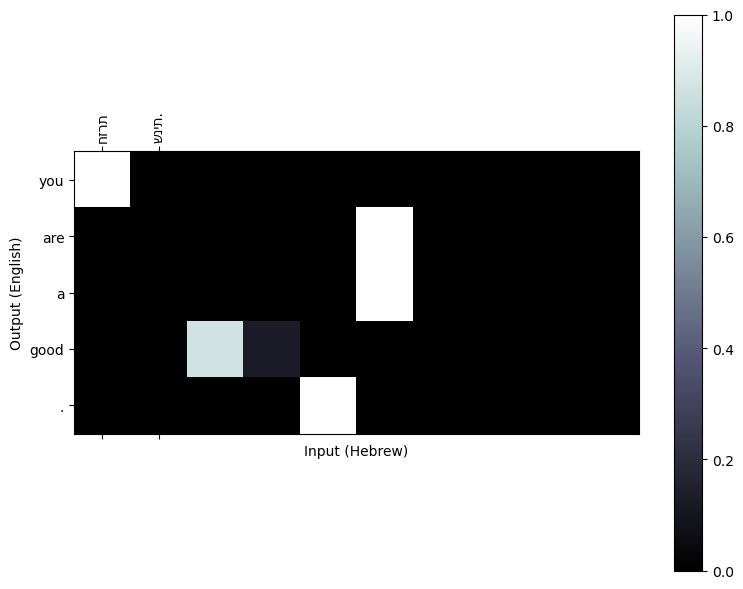


[2]
HE:    אני מצפה לקבלת מכתבך.
TRUE:  i m looking forward to getting your letter .
PRED:  i m impressed with my friends .


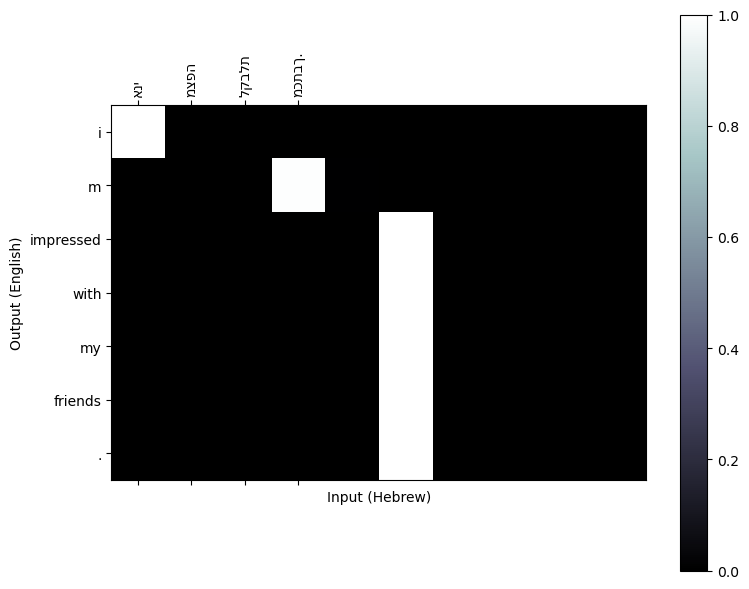


[3]
HE:    אני סומכת על עזרתכם.
TRUE:  i m depending on your help .
PRED:  i m depending on .


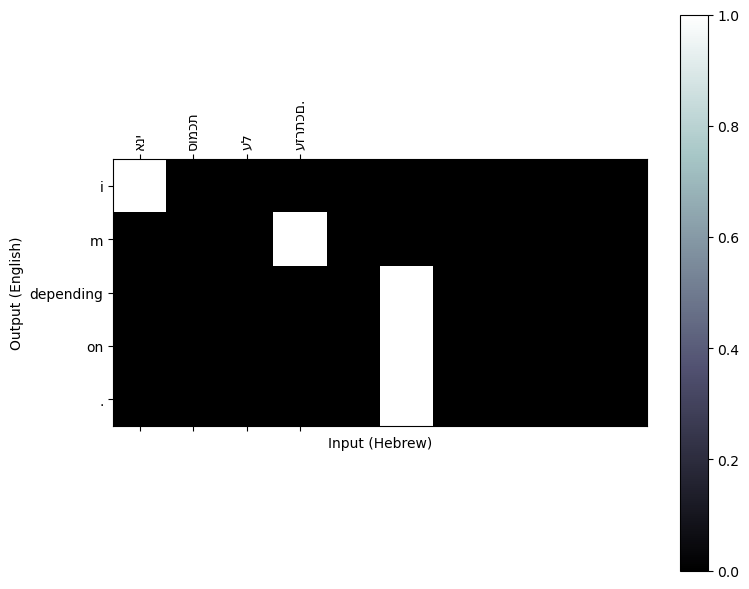


[4]
HE:    אתה במצב רוח די מרומם היום.
TRUE:  you re in quite a mood today .
PRED:  you re quite today .


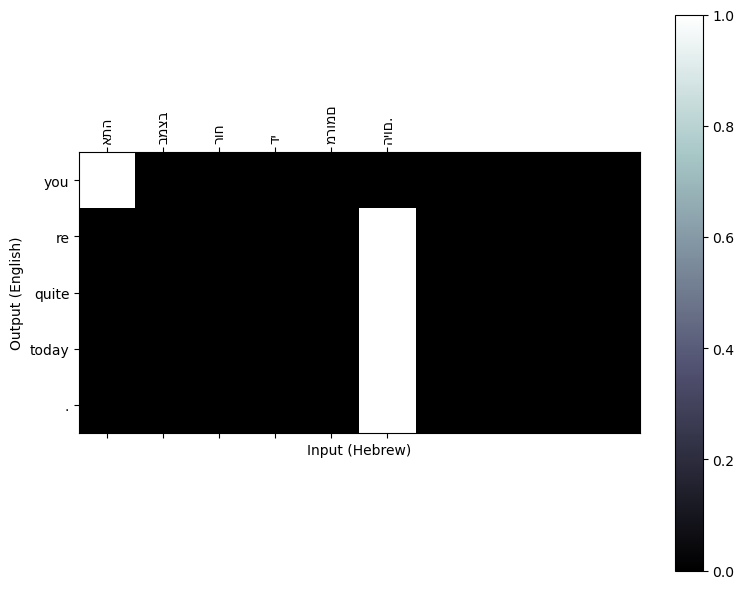


[5]
HE:    אנחנו לא נשארים כאן.
TRUE:  we re not staying here .
PRED:  we re not here .


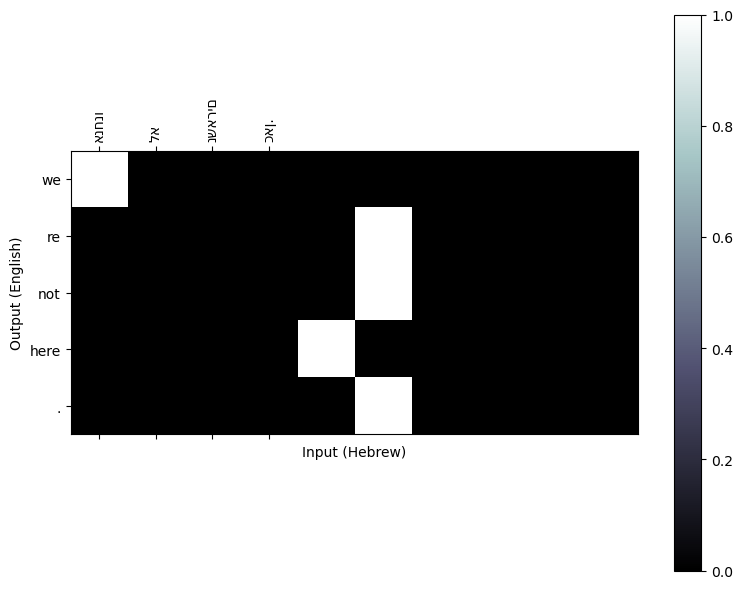

In [30]:

@torch.no_grad()
def show_attention(input_sentence, output_words, attn_matrix):
    """
    input_sentence: str (Hebrew)
    output_words: list[str] (predicted English tokens)
    attn_matrix: Tensor (out_len, MAX_LENGTH)
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    attn = attn_matrix[:len(output_words)].cpu().numpy()
    cax = ax.matshow(attn, cmap="bone")
    fig.colorbar(cax)

    # ticks
    ax.set_xticks(range(len(input_sentence.split())))
    ax.set_yticks(range(len(output_words)))

    ax.set_xticklabels(input_sentence.split(), rotation=90)
    ax.set_yticklabels(output_words)

    ax.set_xlabel("Input (Hebrew)")
    ax.set_ylabel("Output (English)")

    plt.tight_layout()
    plt.show()


def attention_random_5(pairs_he_en, encoder, decoder, input_lang, output_lang, seed=123):
    rng = random.Random(seed)
    sample = rng.sample(pairs_he_en, k=5)

    for i, (he, en_true) in enumerate(sample, 1):
        pred_words, attn = evaluate_sentence(
            encoder, decoder, input_lang, output_lang, he, MAX_LENGTH
        )

        print(f"\n[{i}]")
        print("HE:   ", he)
        print("TRUE: ", en_true)
        print("PRED: ", " ".join(pred_words))

        show_attention(he, pred_words, attn)


# Run 2.c:
attention_random_5(pairs_he_en, encoder, decoder, input_lang, output_lang)

(c) For five randomly selected examples, we visualized the attention weights as a heatmap over source (Hebrew) and target (English) tokens. Each row corresponds to a decoded English token and each column corresponds to an input Hebrew token; darker cells indicate higher attention weight. The plots provide an interpretable alignment showing which Hebrew tokens the decoder relied on when generating each English token, which is expected behavior for an attention-based seq2seq model.

In [33]:
# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -----------------------------
# Data download
# -----------------------------

# IMPORTANT: this matches your unzip command: `-d heb_eng`
if not os.path.exists("heb_eng/heb.txt"):
    print("Downloading dataset...")
    os.system("curl -L -o heb-eng.zip http://www.manythings.org/anki/heb-eng.zip")
    os.system("unzip -o -q heb-eng.zip -d heb_eng")

heb_path = "heb_eng/heb.txt"
assert os.path.exists(heb_path), f"File not found: {heb_path}"

# -----------------------------
# Normalization
# -----------------------------

def unicode_to_ascii(s: str) -> str:
    # keep English side consistent with the tutorial
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )


def normalize_en(s: str) -> str:
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \\1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\\s+", " ", s).strip()
    return s


def normalize_he(s: str) -> str:

    s = s.strip()
    s = re.sub(r"\\s+", " ", s)
    return s


def read_heb_eng_pairs(path: str, max_lines: int | None = None) -> List[Tuple[str, str]]:
    # file format: en \t he
    pairs_local: List[Tuple[str, str]] = []
    with open(path, "r", encoding="utf-8-sig", errors="replace") as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            parts = line.rstrip("\n").split("\t")
            if len(parts) < 2:
                continue
            en_raw, he_raw = parts[0], parts[1]
            en = normalize_en(en_raw)
            he = normalize_he(he_raw)
            if en and he:
                pairs_local.append((he, en))  # Hebrew -> English
    return pairs_local


# -----------------------------
# Filter (eng_prefixes requirement)
# -----------------------------
eng_prefixes = (
    "i am ", "i m ",
    "he is ", "he s ",
    "she is ", "she s ",
    "you are ", "you re ",
    "we are ", "we re ",
    "they are ", "they re ",
)


def filter_pair(he: str, en: str) -> bool:
    return (
        len(he.split()) < MAX_LENGTH
        and len(en.split()) < MAX_LENGTH
        and en.startswith(eng_prefixes)
    )


def filter_pairs(pairs: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    return [(he, en) for (he, en) in pairs if filter_pair(he, en)]


pairs_he_en = read_heb_eng_pairs(heb_path)
print("Total raw pairs:", len(pairs_he_en))
print("Raw example (he, en):", pairs_he_en[0])

pairs_he_en = filter_pairs(pairs_he_en)
print("Filtered pairs:", len(pairs_he_en))
print("Filtered example (he, en):", pairs_he_en[0])

if len(pairs_he_en) == 0:
    raise ValueError(
        "No pairs matched eng_prefixes after filtering. "
        "Try increasing MAX_LENGTH or removing eng_prefixes filter to verify data loading."
    )

# random.shuffle(pairs_he_en)
# pairs_he_en = pairs_he_en[:50000]

# -----------------------------
# Vocabulary
# -----------------------------
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name: str):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence: str):
        for w in sentence.split(" "):
            self.add_word(w)

    def add_word(self, word: str):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


def indexes_from_sentence(lang: Lang, sentence: str):
    return [lang.word2index[w] for w in sentence.split(" ")]


def tensor_from_sentence(lang: Lang, sentence: str):
    idxs = indexes_from_sentence(lang, sentence)
    idxs.append(EOS_token)
    return torch.tensor(idxs, dtype=torch.long, device=device).view(-1, 1)


def tensors_from_pair(pair: Tuple[str, str], input_lang: Lang, output_lang: Lang):
    he, en = pair
    return tensor_from_sentence(input_lang, he), tensor_from_sentence(output_lang, en)


input_lang = Lang("heb")
output_lang = Lang("eng")
for he, en in pairs_he_en:
    input_lang.add_sentence(he)
    output_lang.add_sentence(en)

print("Vocab sizes:", input_lang.n_words, output_lang.n_words)

# -----------------------------
# Models (GRU encoder + Attention decoder)
# -----------------------------


class EncoderRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size_: int):
        super().__init__()
        self.hidden_size = hidden_size_
        self.embedding = nn.Embedding(input_size, hidden_size_)
        self.gru = nn.GRU(hidden_size_, hidden_size_)

    def forward(self, input_token, hidden):
        emb = self.embedding(input_token).view(1, 1, -1)
        out, hidden = self.gru(emb, hidden)
        return out, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size_: int, output_size: int, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size_
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size_)
        self.attn = nn.Linear(hidden_size_ * 2, MAX_LENGTH)
        self.attn_combine = nn.Linear(hidden_size_ * 2, hidden_size_)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size_, hidden_size_)
        self.out = nn.Linear(hidden_size_, output_size)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = torch.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1
        )  # (1, MAX_LENGTH)

        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0),
        )  # (1, 1, H)

        output = torch.cat((embedded[0], attn_applied[0]), 1)      # (1, 2H)
        output = self.attn_combine(output).unsqueeze(0)            # (1, 1, H)
        output = torch.relu(output)

        output, hidden = self.gru(output, hidden)
        output = torch.log_softmax(self.out(output[0]), dim=1)     # (1, V)
        return output, hidden, attn_weights


# -----------------------------
# Training helpers
# -----------------------------
learning_rate = 0.001          # more stable than 0.01 for this setup
teacher_forcing_ratio = 0.7    # higher helps early convergence
clip = 1.0                     # gradient clipping


def train_step(input_tensor, target_tensor, encoder, decoder, enc_opt, dec_opt, criterion):
    encoder_hidden = encoder.init_hidden()
    enc_opt.zero_grad(set_to_none=True)
    dec_opt.zero_grad(set_to_none=True)

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size, device=device)

    # Encode
    for ei in range(min(input_length, MAX_LENGTH)):
        enc_out, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = enc_out[0, 0]

    # Decode
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    loss = 0.0
    use_teacher = random.random() < teacher_forcing_ratio

    if use_teacher:
        for di in range(target_length):
            dec_out, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(dec_out, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            dec_out, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = dec_out.topk(1)
            decoder_input = topi.detach()
            loss += criterion(dec_out, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    # Clip gradients (stability)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    enc_opt.step()
    dec_opt.step()

    return loss.item() / max(target_length, 1)


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {int(s)}s"


def time_since(start, progress):
    now = time.time()
    s = now - start
    es = s / progress if progress > 0 else 0
    rs = es - s
    return f"{as_minutes(s)} (- {as_minutes(rs)})"


# -----------------------------
# Train
# -----------------------------
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# Adam generally converges much faster/more stably than SGD here
enc_opt = optim.Adam(encoder.parameters(), lr=learning_rate)
dec_opt = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

start = time.time()

for ep in range(1, epochs + 1):
    random.shuffle(pairs_he_en)
    total_loss = 0.0

    for pair in pairs_he_en:
        inp, tgt = tensors_from_pair(pair, input_lang, output_lang)
        total_loss += train_step(inp, tgt, encoder, decoder, enc_opt, dec_opt, criterion)

    avg_loss = total_loss / max(len(pairs_he_en), 1)
    print(f"Epoch {ep:02d}/{epochs} | loss={avg_loss:.4f} | {time_since(start, ep/epochs)}")

print("Done.")


device: cpu
Total raw pairs: 136845
Raw example (he, en): ('לך!', 'go')
Filtered pairs: 9615
Filtered example (he, en): ('אני בסדר.', 'i m ok')
Vocab sizes: 7769 3184
Epoch 01/50 | loss=2.9631 | 2m 51s (- 140m 25s)
Epoch 02/50 | loss=2.3815 | 5m 47s (- 138m 52s)
Epoch 03/50 | loss=2.0432 | 8m 38s (- 135m 23s)
Epoch 04/50 | loss=1.7775 | 11m 28s (- 132m 0s)
Epoch 05/50 | loss=1.5751 | 14m 18s (- 128m 48s)
Epoch 06/50 | loss=1.4014 | 17m 8s (- 125m 43s)
Epoch 07/50 | loss=1.2593 | 19m 56s (- 122m 31s)
Epoch 08/50 | loss=1.1527 | 22m 42s (- 119m 13s)
Epoch 09/50 | loss=1.0550 | 25m 25s (- 115m 51s)
Epoch 10/50 | loss=0.9793 | 28m 11s (- 112m 44s)
Epoch 11/50 | loss=0.9223 | 30m 59s (- 109m 52s)
Epoch 12/50 | loss=0.8579 | 33m 51s (- 107m 11s)
Epoch 13/50 | loss=0.8245 | 36m 36s (- 104m 12s)
Epoch 14/50 | loss=0.7907 | 39m 21s (- 101m 11s)
Epoch 15/50 | loss=0.7582 | 42m 6s (- 98m 16s)
Epoch 16/50 | loss=0.7317 | 44m 58s (- 95m 33s)
Epoch 17/50 | loss=0.7043 | 47m 46s (- 92m 44s)
Epoch 18/

In [37]:
evaluate_random_20(pairs_he_en, encoder, decoder, input_lang, output_lang, n=20, seed=SEED)


=== Random evaluation (20 sentences) ===

[01] HE:   אני בהחלט לא לצדך.
     TRUE: i m definitely not on your side
     PRED: i m definitely not on
     OK:   False

[02] HE:   אתם נאים יותר מתמיד.
     TRUE: you re as handsome as ever
     PRED: you re as handsome as ever
     OK:   True

[03] HE:   פחות או יותר גמרנו.
     TRUE: we re pretty much finished
     PRED: we re much finished
     OK:   False

[04] HE:   אני נוקשה.
     TRUE: i m strict
     PRED: i m strict
     OK:   True

[05] HE:   אני לא מרגישה בנוח.
     TRUE: i m not comfortable
     PRED: i m not comfortable
     OK:   True

[06] HE:   אנוכי אנוכי.
     TRUE: i m selfish
     PRED: i m selfish
     OK:   True

[07] HE:   אנו לא נלהבים.
     TRUE: we re unenthusiastic
     PRED: we re unenthusiastic
     OK:   True

[08] HE:   אני באמת מודאג מהעתיד שלך.
     TRUE: i m really concerned about your future
     PRED: i m really concerned about your future
     OK:   True

[09] HE:   קמת מוקדם.
     TRUE: you re up early

0.7


[1]
HE:    זה לגמרי מאחורי.
TRUE:  i m completely over it
PRED:  i m completely over it


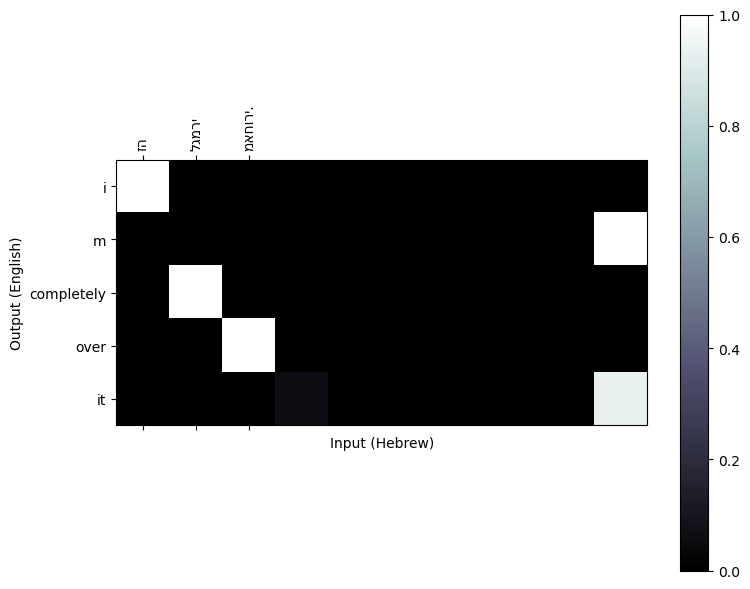


[2]
HE:    הוא במיטה עם שפעת.
TRUE:  he s in bed with the flu
PRED:  he s in bed with the flu


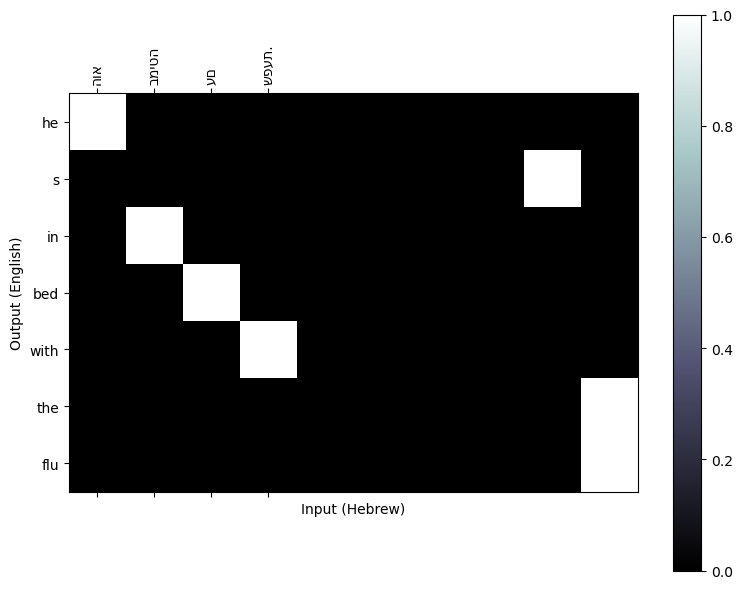


[3]
HE:    את מקסימה.
TRUE:  you re adorable
PRED:  you re adorable


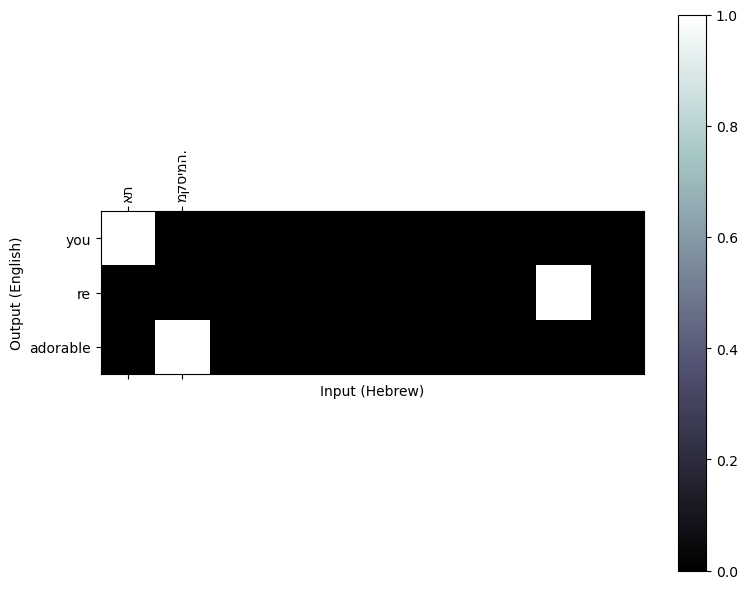


[4]
HE:    אנו מפורסמים.
TRUE:  we re famous
PRED:  we re famous


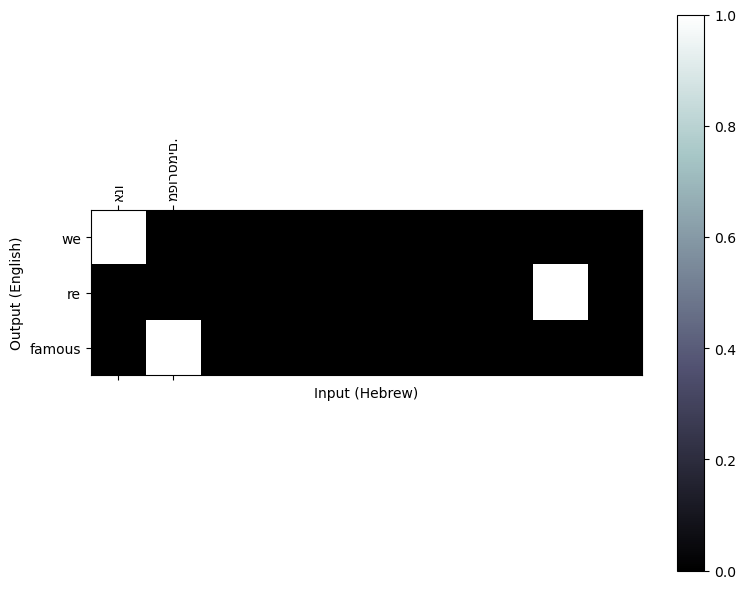


[5]
HE:    אני בהחלט מרגיש טוב יותר.
TRUE:  i m definitely feeling better
PRED:  i m definitely feeling better


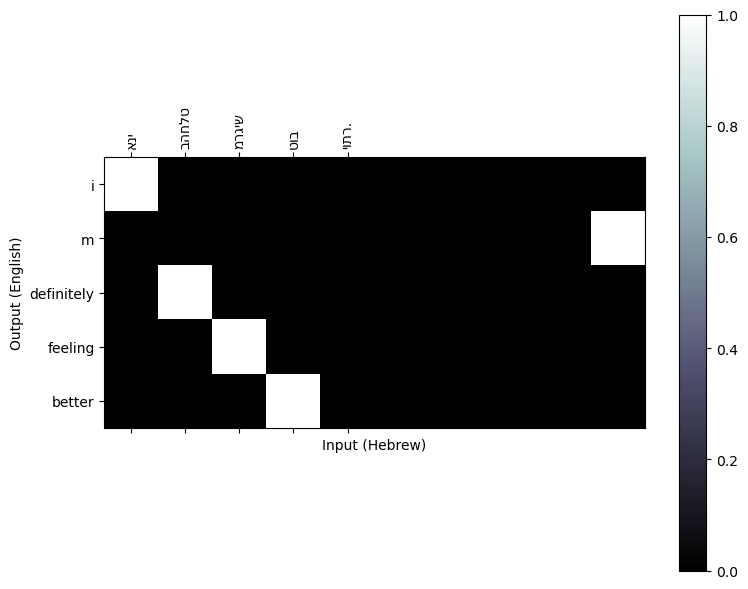

In [38]:
attention_random_5(pairs_he_en, encoder, decoder, input_lang, output_lang)


Model Improvement Summary (Compared to 2.a)

Quantitative evaluation.
In the baseline model (Section 2.a), the exact-match accuracy on 20 randomly selected sentences was low (only 2 correct translations out of 20, corresponding to 10% accuracy). After improving the training strategy, the model achieves 14 correct translations out of 20, corresponding to an exact-match accuracy of 70%. This represents a large absolute improvement of more than +60 percentage points, demonstrating a substantial gain in translation quality.

Training behavior.
The improved model also shows significantly better optimization dynamics. The training loss decreases smoothly from approximately 2.96 at the beginning of training to about 0.58 at the final epoch and remains stable in later epochs. In contrast, the baseline model converged more slowly and to a higher final loss, indicating less effective optimization.

Attention visualization.
The attention heatmaps further support this improvement. In the baseline model, attention was often diffuse and poorly aligned, while in the improved model the attention maps exhibit clearer and more concentrated alignments between Hebrew input tokens and English output tokens (visible as stronger diagonal patterns). This indicates that the model learns more reliable input–output correspondences and produces more coherent translations.

Source of improvement.
Importantly, the architecture remains unchanged (the same GRU-based encoder–decoder with additive attention). The performance gains stem primarily from changes in the training procedure, including the use of the Adam optimizer, gradient clipping, and a higher teacher forcing ratio, which together improve stability and convergence.